<a href="https://colab.research.google.com/github/blessingitodo/A-B-Testing/blob/main/RandomWalks_6_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from typing import List, Dict, Any, Callable, Optional

In [2]:
# ============================================================
# Utility function: normalize a vector
# ============================================================

def normalize(v):
    """
    Normalize a 3D vector.

    Parameters
    ----------
    v : array-like of shape (3,)
        Input vector.

    Returns
    -------
    np.ndarray
        Unit vector (same direction, length = 1).

    Raises
    ------
    Exception
        If the vector has zero length (cannot normalize).
    """
    n = np.linalg.norm(v)      # Compute length (L2 norm) of the vector
    if n == 0:                 # If length is zero...
        raise Exception("Null Vector Error")  # ...we cannot normalize
    return v / n               # Divide by length to get a unit vector

In [3]:
# ============================================================
# Branch class: dynamic object that grows in space
# ============================================================

class Branch:
    """
    A single dendritic branch that grows step-by-step in 3D.

    Behavior summary
    ----------------
    - Stores its own geometry as a list of 3D points.
    - Knows how many total steps ("elongations") it should take.
    - `grow_one_step(...)` generates exactly ONE new point (no death / bifurcation logic).
    - Separate methods handle:
        * `bifurcate()`    – creating child Branch objects at the branch tip
        * `die()`          – marking the branch as dead
        * `is_finished()`  – returns True if the branch is either dead,
                             has bifurcated, or has exhausted its elongations
        * `is_dead()`      – returns True if explicitly marked dead
        * `has_bifurcated()` – returns True if children have been created

    The tree structure is represented by:
        - `parent`   : list with 0 or 1 parent Branch (empty for root)
        - `children` : list of child Branch objects
    """

    def __init__(
        self,
        spec: dict,
        start_point: tuple[float, float, float],
        name: str | None = None,
        description: str | None = None,
        parent: "Branch | None" = None,
    ) -> None:
        """
        Parameters
        ----------
        spec : dict
            The specification dictionary for this branch. Must contain:
                'elongations': int
            and may contain:
                'name'       : str
                'description': str
                'children'   : list of child specs
        start_point : (x, y, z)
            Starting 3D coordinate of this branch.
        name : str, optional
            Override name for this branch. If None, uses spec['name'] if present.
        description : str, optional
            Textual description (e.g., 'apical dendrite', 'basal subtree #1').
        parent : Branch or None
            Parent branch. For the root, this is None.
        """
        self.spec = spec
        self.elongations: int = int(spec["elongations"])

        # Metadata
        self.name: str | None = name if name is not None else spec.get("name")
        self.description: str | None = description if description is not None else spec.get(
            "description"
        )

        # Geometry
        self.points: list[np.ndarray] = [np.array(start_point, dtype=float)]

        # Tree structure
        # parent is stored as a list (0 or 1 element) to match your requirement
        self.parent: list["Branch"] = [] if parent is None else [parent]
        self.children: list["Branch"] = []

        # State flags
        self._dead: bool = False
        self._bifurcated: bool = False

        # Directional persistence
        self.last_direction: np.ndarray | None = None

    # ------------------------------------------------------------------
    # Simple geometry helper properties
    # ------------------------------------------------------------------
    @property
    def steps_grown(self) -> int:
        """Number of segments grown so far (points minus 1)."""
        return max(0, len(self.points) - 1)

    @property
    def length_exhausted(self) -> bool:
        """True if the branch has already taken all its elongation steps."""
        return self.steps_grown >= self.elongations

    # ------------------------------------------------------------------
    # Status query helpers
    # ------------------------------------------------------------------
    def is_dead(self) -> bool:
        """Return True if this branch has been marked dead (no children)."""
        return self._dead

    def has_bifurcated(self) -> bool:
        """Return True if this branch has created children at its tip."""
        return self._bifurcated

    def is_finished(self) -> bool:
        """
        Return True if this branch is no longer active.

        A branch is considered finished if:
        - it has exhausted its elongation length, AND
          either:
            * it has bifurcated (children created), or
            * it has been marked dead (no children),
        OR:
        - it has been explicitly marked dead/bifurcated by external logic.
        """
        return self.is_dead() or self._bifurcated or self.length_exhausted

    # ------------------------------------------------------------------
    # State transition helpers: death & bifurcation
    # ------------------------------------------------------------------
    def die(self) -> None:
        """
        Mark this branch as dead.

        Typically called when the branch has exhausted its elongations
        and has no children to spawn.
        """
        self._dead = True

    def bifurcate(self) -> list["Branch"]:
        """
        Create child branches at this branch's current tip.

        Returns
        -------
        children : list[Branch]
            Newly created child Branch objects (may be empty).

        Behavior
        --------
        - Looks for 'children' in self.spec; if none, returns [] and does not
          change state.
        - If there are child specs:
            * creates a Branch for each child spec
              starting from this branch's endpoint,
            * appends them to self.children,
            * sets _bifurcated = True.
        """

        child_specs = self.spec.get("children") or []
        if not child_specs:
            return []

        new_children = []
        # iterate over a COPY to avoid any weird mutation/aliasing issues
        for child_spec in list(child_specs):
            if not isinstance(child_spec, dict):
                raise TypeError(f"Child spec must be a dict, got: {type(child_spec)} -> {child_spec}")

            child = Branch(
                spec=child_spec,
                start_point=self.points[-1],
                parent=self,
            )
            new_children.append(child)

        self.children.extend(new_children)
        self._bifurcated = True
        return new_children


    # ------------------------------------------------------------------
    #  Core geometry: one growth step
    # ------------------------------------------------------------------
    def grow_one_step(
        self,
        step_length: float = 1.0,
        bias_func=None,
        w_prev: float = 0.6,
        w_rand: float = 1.0,
        w_bias: float = 1.0,
    ) -> np.ndarray | None:
        """
        Generate exactly ONE new point for this branch.

        Behavior summary
        ----------------
        - Assumes the branch is still active (not finished).
        - Does NOT check for death, bifurcation, or completion.
          It only:
            1. Draws a random 3D direction.
            2. Adds an optional bias vector.
            3. Adds an optional correlation with the previous direction
               (to reduce tortuosity).
            4. Normalizes the resulting vector.
            5. Moves from the current tip by `step_length` along this direction.
            6. Stores the new point and updates `last_direction`.

        Parameters
        ----------
        step_length : float
            Length of this growth step.
        bias_func : callable or None
            bias_func(p) -> np.ndarray(3,), spatial bias evaluated at the
            current endpoint position p. If None, no bias is applied.
        w_prev, w_rand, w_bias : float
            Weights for the previous direction, random direction, and bias
            respectively. Together they control smoothness and guidance.

        Returns
        -------
        np.ndarray or None
            The new point after this step, or None if the branch is already
            finished and should not grow further.
        """
        # If external logic says we are finished, do not grow further
        if self.is_finished():
            return None

        # 1. Unbiased random direction
        v_rand = normalize(np.random.rand(3) - 0.5)

        # 2. Bias vector at current point
        current_point = self.points[-1]
        b = bias_func(current_point) if bias_func else np.zeros(3)

        # Previous direction: for the very first step, we assume no previous direction.
        v_prev = self.last_direction if self.last_direction is not None else np.zeros(3)

        # 3. Combine: v_new = w_prev * v_prev + w_rand * v_rand + w_bias * b
        v = w_prev * v_prev + w_rand * v_rand + w_bias * b

        # If the combined vector accidentally becomes zero, fall back to random.
        v = normalize(v) if np.linalg.norm(v) > 0 else v_rand

        # Store this direction so the next step can correlate with it.
        self.last_direction = v

        # 4. Move to new point
        new_point = current_point + step_length * v
        self.points.append(new_point)

        if self.length_exhausted:
          if self.spec.get("children"):
              self.bifurcate()
          else:
              self.die()

        return new_point


    # ------------------------------------------------------------------
    # Branch Statistics
    # ------------------------------------------------------------------

    def length(self):
        """
        Total Euclidean length of the branch.
        """
        length = 0.0
        for p1, p2 in zip(self.points[:-1], self.points[1:]):
            length += np.linalg.norm(p2 - p1)
        return length

    # remove num bifurcations
    def num_bifurcations(self):
        """
        Number of bifurcations contributed by this branch.
        """
        return int(self.has_bifurcated())

    def sholl_profile(self, center, max_dist, binsz):
      """
      Compute a binned Sholl profile for this Branch.

      This method counts outward crossings of the branch polyline through
      concentric spherical shells centered at `center`. Distances are binned
      into shells of thickness `binsz`, up to `max_dist`.

      Parameters
      ----------
      center : array-like (3,)
          Center point (typically the soma) used for radial distance calculations.
      max_dist : float
          Maximum radius to consider.
      binsz : float
          Bin (shell) size.

      Returns
      -------
      np.ndarray
          1D array of intersection counts per radial bin for this branch.
          Bin k corresponds approximately to radii in [k*binsz, (k+1)*binsz).
      """
      center = np.array(center, dtype=float)
      nbin = int(max_dist / binsz) + 1
      intersections = np.zeros(nbin, dtype=int)

      # Count outward crossings between consecutive points
      for i in range(len(self.points) - 1):
          d1 = np.linalg.norm(self.points[i] - center)
          d2 = np.linalg.norm(self.points[i + 1] - center)

          bin1 = int(d1 / binsz)
          bin2 = int(d2 / binsz)

          # Count only outward crossings (same convention as your Tree)
          if bin1 < bin2 and bin2 < nbin:
              intersections[bin2] += 1

      return intersections

In [4]:
# ============================================================
# Tree class: dynamic object that encapsulates multiple branches
# ============================================================
class Tree:
    """
    A Tree encapsulates a set of Branch objects grown from a single root
    branch specification (a nested dictionary).

    A Tree can be interpreted as one dendritic tree (e.g., apical tree,
    basal tree, axonal tree), depending on how you define its root spec
    and biases.
    """

    def __init__(self, root_branch_dict, start_point=(0, 0, 0), name="tree", description=None):
        """
        Parameters
        ----------
        root_branch_dict : dict
            Root branch specification dict with keys:
                'elongations': int
                'children': None or list of branch dicts
            (optionally: 'name', 'description')
        start_point : tuple[float, float, float]
            Start point in 3D (e.g. soma location).
        name : str
            Name of this tree (e.g., "apical", "basal_1").
        description : str or None
            Human-readable description/metadata for the tree.
        """
        self.root_branch_dict = root_branch_dict
        self.start_point = np.array(start_point, dtype=float)
        self.name = name
        self.description = description
        self.branches = [] # This will be populated by Branch objects during growth, not directly from generate_branch return

        # This will be filled after growth
        self.coords = None  # list of {"branch": spec_dict, "points": [[x,y,z], ...]}

    def grow(self, step_length=1.0, bias_func=None):
        """
        Grow the tree using the same iterative scheduling approach as generate_branch().

        Parameters
        ----------
        step_length : float
            Step length for branch growth.
        bias_func : callable or None
            bias_func(p)->np.ndarray(3,), applied inside Branch.grow_one_step().

        Returns
        -------
        coords : list of dict
            The grown branch geometries (same format as generate_branch()).
        """
        self.coords = generate_branch(
            root_branch_dict=self.root_branch_dict,
            start_point=tuple(self.start_point),
            step_length=step_length,
            bias_func=bias_func
        )
        return self.coords

    # ----------------------------------------------------------------------
    # Tree Statistics
    # ----------------------------------------------------------------------
    def num_branches(self):
      """
      Total number of branches in the tree.
      Returns
      -------
      int
          Number of branches in the tree. Returns 0 if the tree has not yet
          been grown (i.e., `self.coords` is None).
      """
      if self.coords is None:
          return 0
      return len(self.coords)

    def length(self):
      """
      Total Euclidean length of all branches in the tree.
      Returns
      -------
      float
          Total length of the tree in the same units as the growth step
          length. Returns 0.0 if the tree has not yet been grown
          (i.e., `self.coords` is None).
      """
      if self.coords is None:
          return 0.0

      total = 0.0
      for rec in self.coords:
          pts = np.array(rec["points"], dtype=float)
          if len(pts) < 2:
              continue
          diffs = pts[1:] - pts[:-1]
          total += np.linalg.norm(diffs, axis=1).sum()
      return float(total)

    def bifurcation_count(self):
        """
        Count bifurcations from the *spec* (a branch bifurcates if it has children).
        """
        if self.coords is None:
            return 0
        count = 0
        for rec in self.coords:
            spec = rec["branch"]
            children = spec.get("children") if isinstance(spec, dict) else None
            if children:
                count += 1
        return count

    def sholl_profile(self, center, max_dist, binsz):
        """
        Compute a binned Sholl profile for the full tree.

        Parameters
        ----------
        center : array-like (3,)
            Soma (center) location.
        max_dist : float
            Maximum radius to consider.
        binsz : float
            Bin (shell) size.

        Returns
        -------
        np.ndarray
            Array of intersection counts per radial bin. Bin k corresponds to
            radii in [k*binsz, (k+1)*binsz).
        """
        if self.coords is None:
          nbin = int(max_dist / binsz) + 1
          intersections = np.zeros(nbin, dtype=int)
          intersections[0] = 1
          return intersections

        center = np.array(center, dtype=float)
        nbin = int(max_dist / binsz) + 1
        intersections = np.zeros(nbin, dtype=int)
        intersections[0] = 1

        for rec in self.coords:
            pts = np.array(rec["points"], dtype=float)
            for i in range(len(pts) - 1):
                bin1 = int(np.linalg.norm(pts[i] - center) / binsz)
                bin2 = int(np.linalg.norm(pts[i + 1] - center) / binsz)
                if bin1 < bin2 and bin2 < len(intersections):
                    intersections[bin2] += 1

        return intersections

In [5]:
# ============================================================
# Neuron class: dynamic object that encapsulates multiple trees
# ============================================================
class Neuron:
    """
    A Neuron encapsulates multiple Trees.
    For example: basal dendrites + apical dendrites (and optionally axon).
    """

    def __init__(self, soma=(0, 0, 0), name="neuron", description=None):
        """
        Parameters
        ----------
        soma : tuple[float, float, float]
            Soma position in 3D.
        name : str
            Name/label of the neuron.
        description : str or None
            Metadata description.
        """
        self.soma = np.array(soma, dtype=float)
        self.name = name
        self.description = description

        # Container of Tree objects
        self.trees = []

    def add_tree(self, tree: Tree):
        """
        Attach a Tree to this neuron.

        If you want all trees rooted at soma, you can enforce it here by setting
        tree.start_point = soma.
        """
        self.trees.append(tree)

    def grow_all(self, step_length=1.0, bias_funcs=None):
        """
        Grow all trees in this neuron.

        Parameters
        ----------
        step_length : float
            Step length to use for all trees.
        bias_funcs : list[callable] or None
            A list of bias functions aligned with self.trees.
            - If None: no bias for any tree.
            - If provided: len(bias_funcs) must match len(self.trees).

        Returns
        -------
        results : list
            A list of coords outputs (one per tree).
        """
        if bias_funcs is None:
            bias_funcs = [None] * len(self.trees)
        if len(bias_funcs) != len(self.trees):
            raise ValueError("bias_funcs must be None or have same length as trees")

        results = []
        for tree, bf in zip(self.trees, bias_funcs):
            results.append(tree.grow(step_length=step_length, bias_func=bf))
        return results

    # ------------------------------------------------------------------------
    # Neuron Statistics
    # ------------------------------------------------------------------------
    def num_trees(self):
        """Number of trees in the neuron."""
        return len(self.trees)

    def num_branches(self):
        """Total number of branches across all trees."""
        return sum(tree.num_branches() for tree in self.trees)

    def length(self):
        """Total geometric length of the neuron."""
        return sum(tree.length() for tree in self.trees)

    def bifurcation_count(self):
        """Total number of bifurcations across all trees."""
        return sum(tree.bifurcation_count() for tree in self.trees)

    def sholl_profile(self, center, max_dist, binsz):
        """
        Count segment intersections with spheres of given radii around 'center'.
        Returns dict {radius: intersections}.
        """
        nbin = int(max_dist / binsz) + 1
        intersections = np.zeros(nbin, dtype=int)
        intersections[0] = 1
        for tree in self.trees:
          tree_profile = tree.sholl_profile(center, max_dist, binsz)
          # The tree_profile is already an array of counts, so directly add it
          # Ensure the tree_profile does not exceed the nbin size for safety
          if len(tree_profile) > nbin:
              intersections += tree_profile[:nbin]
          else:
              intersections[:len(tree_profile)] += tree_profile
        return intersections

In [6]:
# ============================================================
# Helper: get a name for a branch dictionary
# ============================================================
def get_name_from_dict(d: dict, fallback: str) -> str:
    """
    Return a branch name from the specification dictionary, or a fallback.

    Parameters
    ----------
    d : dict
        Branch specification dictionary.
    fallback : str
        Fallback name if 'name' is not present.

    Returns
    -------
    str
        The explicit name if provided, otherwise the fallback.
    """
    return d.get("name", fallback)

In [7]:
# ============================================================
# Main function: generate_branch
# ============================================================

def generate_branch(
    root_branch_dict: dict,
    start_point=(0.0, 0.0, 0.0),
    step_length: float = 1.0,
    bias_func=None, verbose=False):
    """
    Grow a full dendritic tree defined by nested branch dictionaries.

    Behavior summary
    ----------------
    - Wraps each branch specification dict in a Branch object.
    - Maintains an 'active' list of branches that are still growing.
    - For each active branch:
        * Calls branch.grow_one_step(...) once.
        * When the branch's elongation length is exhausted:
            - If its spec has children → branch.bifurcate(), new children
              are added to the active list.
            - Otherwise → branch.die().
        * Finished branches are collected into a list.
    - Continues until there are no active branches left.
    - Returns a list of geometry records suitable for plotting or analysis.

    Parameters
    ----------
    root_branch_dict : dict
        Root branch specification (with 'elongations' and optional 'children').
    start_point : (x, y, z)
        Starting soma location in 3D space.
    step_length : float
        Distance moved per growth step.
    bias_func : callable or None
        Spatial bias function passed through to Branch.grow_one_step.

    Returns
    -------
    coords : list of dict
        Each element:
            {
                'branch': <original branch spec dict>,
                'points': [[x, y, z], ...]
            }
        for every finished branch (including internal branches and terminals).
    """
    # Create root branch
    root_name = get_name_from_dict(root_branch_dict, "root")
    # Pass name/description override; Branch will also read from spec
    root_branch = Branch(
        spec=root_branch_dict,
        start_point=start_point,
        name=root_name,
        description=root_branch_dict.get("description"),
        parent=None,
    )

    active: List[Branch] = [root_branch]
    finished: List[Branch] = []

    while active:
        new_children: List[Branch] = []

        for br in list(active):
            # Skip if already finished for any reason
            if br.is_finished():
                continue

            # One geometric step
            new_point = br.grow_one_step(step_length=step_length, bias_func=bias_func)

            if new_point is None:
                continue

            # If this branch has now exhausted its elongations, decide:
            if br.length_exhausted:
                child_specs = br.spec.get("children") or []

                if child_specs:
                    # Bifurcation: create child Branch objects at the tip
                    children = br.bifurcate()
                    new_children.extend(children)
                else:
                    # No children → terminal branch
                    br.die()

                finished.append(br)

        # Keep only branches that are still active
        active = [b for b in active if not b.is_finished()]

        # Add any newly created children for the next iteration
        active.extend(new_children)

    # Convert finished branches to coords format
    coords = []
    for br in finished:
        coords.append(
            {
                "branch": br.spec,
                "points": [p.tolist() for p in br.points],
            }
        )

    return coords

    if verbose:
      print(f"Branch {branch_obj.name} finished={branch_obj.finished}")

In [8]:
def plot_branches(coords, title="", limits=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for entry in coords:
        pts = np.array(entry["points"])
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], lw=2, color="black")

    if title:
        ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # Apply limits if provided
    if limits is not None:
        xmin, xmax, ymin, ymax, zmin, zmax = limits
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)

        # Corrected tick generation for each axis
        # Use floor/ceil to ensure ticks cover the entire range
        x_ticks = np.arange(np.floor(xmin), np.ceil(xmax) + 1, 1)
        y_ticks = np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1)
        z_ticks = np.arange(np.floor(zmin), np.ceil(zmax) + 1, 1)

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.set_zticks(z_ticks)

    # Set box aspect ratio consistently
    ax.set_box_aspect((1, 1, 1))

    plt.show()

In [9]:
def plot_tree(tree: Tree, title=None):
    """
    Plot a single tree using the coords stored in tree.coords.
    """
    if tree.coords is None:
        raise ValueError("Tree has no coords yet. Call tree.grow(...) first.")
    plot_branches(tree.coords)  # your existing plot_branches

In [10]:
def plot_neuron(neuron: Neuron, title=None):
    """
    Plot all trees in a neuron in one 3D plot.
    """
    all_coords = []
    for tree in neuron.trees:
        if tree.coords is None:
            continue
        all_coords.extend(tree.coords)

    if not all_coords:
        raise ValueError("No grown trees to plot. Call neuron.grow_all(...) first.")

    plot_branches(all_coords)

In [11]:
def plot_sholl(counts, binsz, title="Sholl Plot", xlabel="Radius", ylabel="Intersections"):
    """
    Plot a binned Sholl profile returned by Tree/Neuron.sholl_profile().

    Parameters
    ----------
    counts : array-like
        1D array of intersection counts per radial bin. Typically returned by
        sholl_profile(center, max_dist, binsz).
    binsz : float
        Bin (shell) size used to compute the Sholl profile. Radii are computed
        as r_k = k * binsz.
    title : str, optional
        Plot title.
    xlabel, ylabel : str, optional
        Axis labels.

    Returns
    -------
    radii : np.ndarray
        Radii used for the x-axis (k * binsz).
    counts : np.ndarray
        Counts used for the y-axis (as a NumPy array).
    """
    counts = np.asarray(counts)
    radii = np.arange(len(counts)) * binsz

    plt.figure()
    plt.plot(radii, counts)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return radii, counts


In [12]:
# ============================================================
# Application example
# ============================================================

if __name__ == "__main__":
    # --------------------------------------
    # 1. Define branch specifications (tree)
    # --------------------------------------
    a = {
        'name': 'a',
        'elongations': 7,
        'children': [
            {'name': 'a1', 'elongations': 1, 'children': None},
            {'name': 'a2', 'elongations': 4, 'children': None}
        ]
    }

    b = {
        'name': 'b',
        'elongations': 10,
        'children': None
    }

    c = {
        'name': 'c',
        'elongations': 15,
        'children': [
            {'name': 'c1', 'elongations': 3, 'children': None},
            {
                'name': 'c2',
                'elongations': 5,
                'children': [
                    {'name': 'c2.1', 'elongations': 2, 'children': None},
                    {'name': 'c2.2', 'elongations': 6, 'children': None}
                ]
            }
        ]
    }

    # Root branch with children a, b, c
    branches = {
        'name': 'root',
        'elongations': 5,
        'children': [a, b, c]
    }

    soma_point = (1.0, 2.0, 5.0)

    # --------------------------------------
    # 2. Random-walk growth
    # --------------------------------------
    print("\n=== Unbiased growth ===")
    coords = generate_branch(
        root_branch_dict=branches,
        start_point=soma_point,
        step_length=1.0,
        bias_func=None      # <-- no bias: pure random walk
    )

    print("\nUnbiased branches grown:", len(coords))




=== Unbiased growth ===

Unbiased branches grown: 10


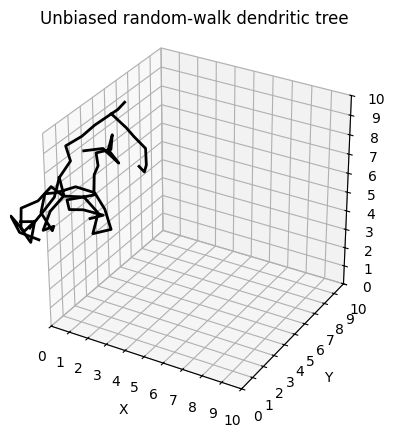

In [13]:
# Plot them using the locally redefined function
plot_branches(coords, title="Unbiased random-walk dendritic tree", limits=(0, 10, 0, 10, 0, 10))

In [14]:
# ============================================================
# Spatial bias function for up_down
# ============================================================

def bias_up_down(direction=+1, strength=1.0, axis=2):
    """
    Create a spatial bias that orients growth upward or downward
    along a given axis (default: z-axis).

    Parameters
    ----------
    direction : int
        +1 for upward, -1 for downward.
    strength : float
        Magnitude of the bias vector (relative contribution).
    axis : int
        Axis index along which to push (0=x, 1=y, 2=z).

    Returns
    -------
    bias_fn : callable
        bias_fn(p) -> np.ndarray of shape (3,)
        `p` is the current 3D position (ignored here; bias is spatially uniform).

    Explanation
    -----------
    This returns a *constant* vector like [0, 0, +strength] (for z-up), which
    will be added to the random direction inside grow_one_step, then
    re-normalized. The result is a random walk with a preferred vertical trend.
    """
    def bias_fn(p):
        v = np.zeros(3)
        v[axis] = direction * strength
        return v

    return bias_fn

In [15]:
# ============================================================
# Spatial bias function for cylinder
# ============================================================

def bias_cylinder(radius, strength=1.0):
    """
    Create a spatial bias that keeps growth inside a vertical cylinder
    of given radius around the z-axis.

    Cylinder axis: z-axis
    Radial distance: r = sqrt(x^2 + y^2)

    Parameters
    ----------
    radius : float
        Cylinder radius (fixed ahead of time).
    strength : float
        Controls how strongly points are pushed back toward the cylinder axis
        when they move outside the boundary.

    Returns
    -------
    bias_fn : callable
        bias_fn(p) -> np.ndarray of shape (3,)
        `p` is the current 3D position [x, y, z].

    Behavior
    --------
    - If the point is inside the cylinder (r <= radius): bias = 0 vector.
    - If outside (r > radius):
        * Compute unit vector pointing radially inward in the x-y plane.
        * Scale it by how far the point overshoots the radius (normalized),
          and by `strength`.

    This creates a "soft wall" that nudges growth back toward the cylinder.
    """
    R = float(radius)

    def bias_fn(p):
        x, y, z = p
        r = np.sqrt(x**2 + y**2)  # distance from the z-axis

        # Inside cylinder: no bias. You could add a weak inward pull if desired.
        if r <= R or r == 0:
            return np.zeros(3)

        # Unit inward vector in x-y plane
        inward_xy = np.array([-x, -y, 0.0]) / r

        # Overshoot fraction: how far outside the boundary we are, normalized by R
        overshoot = (r - R) / R

        return strength * overshoot * inward_xy

    return bias_fn

In [16]:
def combine_biases(bias_fns, weights=None):
    """
    Linearly combine multiple spatial bias functions using NumPy (vectorized).

    Parameters
    ----------
    bias_fns : list of callables
        Each must have the form: bias_fn(p) -> np.ndarray of shape (3,)
    weights : list of floats or None
        Linear weights for each bias function. If None, all weights = 1.0.

    Returns
    -------
    combined_bias : callable
        combined_bias(p) = sum_i ( weights[i] * bias_fns[i](p) )
        computed using NumPy vectorization instead of Python loops.
    """
    if weights is None:
        weights = np.ones(len(bias_fns), dtype=float)
    else:
        weights = np.array(weights, dtype=float)
        if len(weights) != len(bias_fns):
            raise ValueError("weights and bias_fns must have the same length")

    def combined_bias(p):
        """
        Compute combined bias at point p using NumPy vectorization.

        Steps:
        1. Evaluate each bias function → shape (n_biases, 3)
        2. Multiply by weights (broadcasting)
        3. Sum across all biases → shape (3,)
        """
        # Stack all bias vectors into a 2D array: shape = (num_biases, 3)
        bias_matrix = np.stack([fn(p) for fn in bias_fns], axis=0)

        # Apply weights using broadcasting: (num_biases, 1)
        weighted = weights[:, None] * bias_matrix

        # Sum across biases to get the final 3D vector
        return weighted.sum(axis=0)

    return combined_bias


=== Unbiased growth ===

Unbiased branches grown: 10


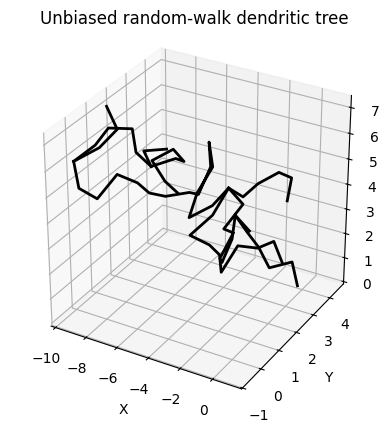


=== Biased growth (upward + cylinder) ===

Biased branches grown: 10


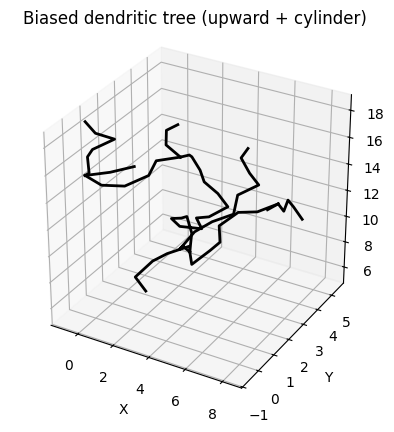

In [17]:
# ============================================================
# Application example
# ============================================================

if __name__ == "__main__":
    # --------------------------------------
    # 1. Define branch specifications (tree)
    # --------------------------------------
    a = {
        'name': 'a',
        'elongations': 7,
        'children': [
            {'name': 'a1', 'elongations': 1, 'children': None},
            {'name': 'a2', 'elongations': 4, 'children': None}
        ]
    }

    b = {
        'name': 'b',
        'elongations': 10,
        'children': None
    }

    c = {
        'name': 'c',
        'elongations': 15,
        'children': [
            {'name': 'c1', 'elongations': 3, 'children': None},
            {
                'name': 'c2',
                'elongations': 5,
                'children': [
                    {'name': 'c2.1', 'elongations': 2, 'children': None},
                    {'name': 'c2.2', 'elongations': 6, 'children': None}
                ]
            }
        ]
    }

    # Root branch with children a, b, c
    branches = {
        'name': 'root',
        'elongations': 5,
        'children': [a, b, c]
    }

    soma_point = (1.0, 2.0, 5.0)

    # --------------------------------------
    # 2. Unbiased random-walk growth
    # --------------------------------------
    print("\n=== Unbiased growth ===")
    coords_unbiased = generate_branch(
        root_branch_dict=branches,
        start_point=soma_point,
        step_length=1.0,
        bias_func=None      # <-- no bias: pure random walk
    )

    print("\nUnbiased branches grown:", len(coords_unbiased))
    plot_branches(coords_unbiased, title="Unbiased random-walk dendritic tree")

    # --------------------------------------
    # 3. Define spatial biases
    # --------------------------------------
    # Bias 1: gently upward along +z
    up_bias = bias_up_down(direction=+1, strength=0.5, axis=2)

    # Bias 2: keep growth within a cylinder of radius 10 around the z-axis
    cyl_bias = bias_cylinder(radius=10.0, strength=2.0)

    # Combine them: mostly upward, with weaker cylinder confinement
    combined_bias = combine_biases(
        [up_bias, cyl_bias],
        weights=[1.0, 0.5]
    )

    # --------------------------------------
    # 4. Biased growth (upward + cylindrical)
    # --------------------------------------
    print("\n=== Biased growth (upward + cylinder) ===")
    coords_biased = generate_branch(
        root_branch_dict=branches,
        start_point=soma_point,
        step_length=1.0,
        bias_func=combined_bias   # <-- apply combined bias here
    )

    print("\nBiased branches grown:", len(coords_biased))
    plot_branches(coords_biased, title="Biased dendritic tree (upward + cylinder)")

In [18]:
# Tree 1 spec (example)
tree1_spec = {
    "name": "tree1_root",
    "description": "Tree 1 root",
    "elongations": 6,
    "children": [
        {"name": "t1_a", "elongations": 8, "children": None},
        {"name": "t1_b", "elongations": 5, "children": [
            {"name": "t1_b1", "elongations": 4, "children": None},
            {"name": "t1_b2", "elongations": 6, "children": None},
        ]},
    ]
}

# Tree 2 spec (different structure)
tree2_spec = {
    "name": "tree2_root",
    "description": "Tree 2 root (more branching)",
    "elongations": 4,
    "children": [
        {"name": "t2_a", "elongations": 6, "children": [
            {"name": "t2_a1", "elongations": 3, "children": None},
            {"name": "t2_a2", "elongations": 3, "children": None},
        ]},
        {"name": "t2_b", "elongations": 7, "children": None},
        {"name": "t2_c", "elongations": 5, "children": [
            {"name": "t2_c1", "elongations": 2, "children": None},
            {"name": "t2_c2", "elongations": 4, "children": None},
        ]},
    ]
}


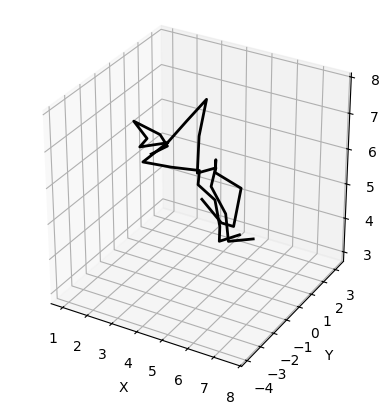

Tree branches: 5
Tree length: 29.0
Tree bifurcations: 2
Tree Sholl Profile: [1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
# Create Tree objects rooted at slightly different soma-adjacent starts
tree1 = Tree(tree1_spec, start_point=(1, 2, 5), name="Tree1", description="apical-like")

tree1.grow()
plot_tree(tree1)

print("Tree branches:", tree1.num_branches())
print("Tree length:", tree1.length())
print("Tree bifurcations:", tree1.bifurcation_count())
print("Tree Sholl Profile:", tree1.sholl_profile(center=soma_point, max_dist=50, binsz=1))

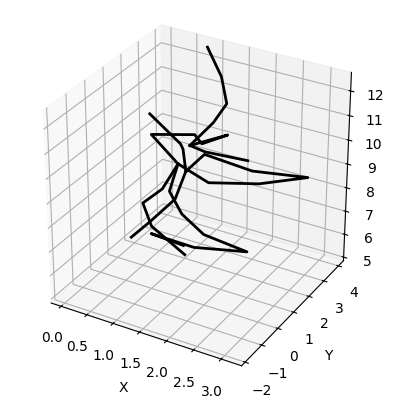

Tree branches: 8
Tree length: 34.0
Tree bifurcations: 3
Tree Sholl Profile: [1 2 2 1 2 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
tree2 = Tree(tree2_spec, start_point=(1, 2, 5), name="Tree2", description="basal-like")

tree2.grow()
plot_tree(tree2)

print("Tree branches:", tree2.num_branches())
print("Tree length:", tree2.length())
print("Tree bifurcations:", tree2.bifurcation_count())
print("Tree Sholl Profile:", tree2.sholl_profile(center=soma_point, max_dist=50, binsz=1))

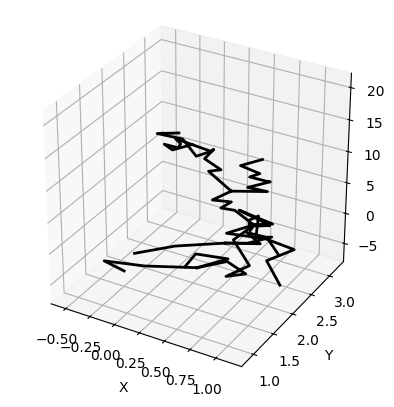

Neuron branches: 13
Neuron length: 63.0
Neuron Sholl Profile: [3 2 2 2 4 4 5 5 5 6 7 6 6 3 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
# Create Neuron and attach both trees
neuron = Neuron(soma=(1, 2, 5), name="Neuron1", description="two-tree neuron")
neuron.add_tree(tree1)
neuron.add_tree(tree2)

up_bias = combine_biases(
    [bias_up_down(direction=+1, strength=3.0), bias_cylinder(radius=3.0, strength=5.0)],
    weights=[1.0, 1.0])

down_bias = combine_biases(
    [bias_up_down(direction=-1, strength=2.0), bias_cylinder(radius=4.0, strength=4.0)],
    weights=[1.0, 1.0])

neuron.grow_all(step_length=1.0, bias_funcs=[up_bias, down_bias])
plot_neuron(neuron)

print("Neuron branches:", neuron.num_branches())
print("Neuron length:", neuron.length())
print("Neuron Sholl Profile:", neuron.sholl_profile(center=soma_point, max_dist=50, binsz=1))

Branch length: 4.999999999999999
Branch bifurcations: 1
Branch Sholl: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


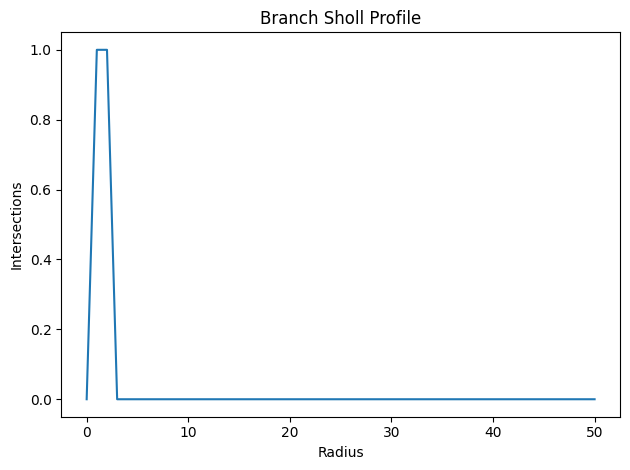

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [22]:
branch = Branch(spec=branches, start_point=soma_point)

while not branch.length_exhausted:
    branch.grow_one_step(step_length=1.0, bias_func=None)

print("Branch length:", branch.length())
print("Branch bifurcations:", branch.num_bifurcations())

counts = branch.sholl_profile(center=soma_point, max_dist=50, binsz=1)
print("Branch Sholl:", counts)
plot_sholl(counts, binsz=1, title="Branch Sholl Profile")


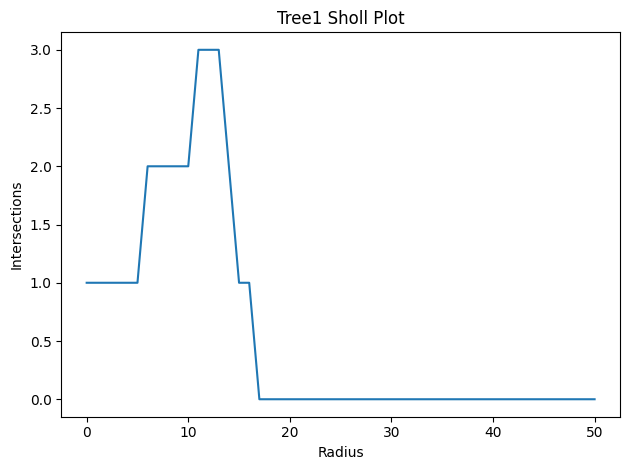

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 2, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [23]:
counts = tree1.sholl_profile(center=soma_point, max_dist=50, binsz=1)
plot_sholl(counts, binsz=1, title="Tree1 Sholl Plot")



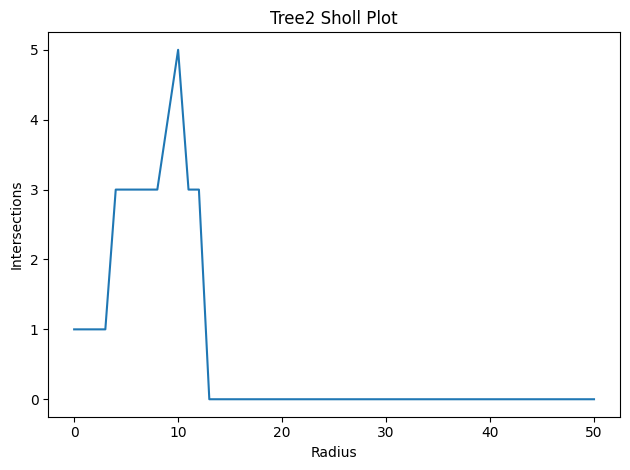

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([1, 1, 1, 1, 3, 3, 3, 3, 3, 4, 5, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [24]:
counts = tree2.sholl_profile(center=soma_point, max_dist=50, binsz=1)
plot_sholl(counts, binsz=1, title="Tree2 Sholl Plot")

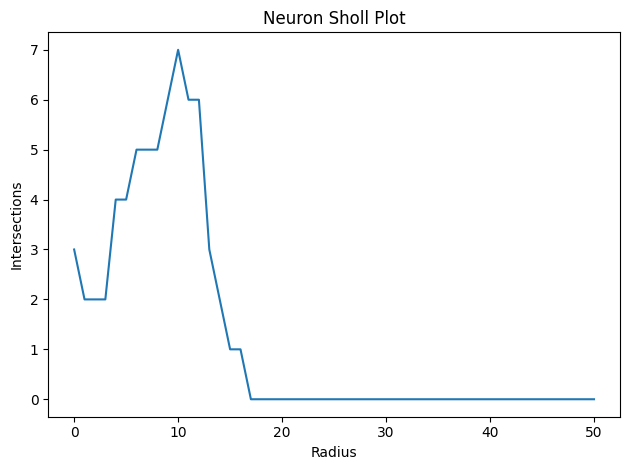

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 array([3, 2, 2, 2, 4, 4, 5, 5, 5, 6, 7, 6, 6, 3, 2, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [25]:
counts = neuron.sholl_profile(center=soma_point, max_dist=50, binsz=1)
plot_sholl(counts, binsz=1, title="Neuron Sholl Plot")

In [43]:
def coords_bounds(coords, pad=2.0, tick_step=1.0):
    """
    Return cubic axis limits + identical ticks for x/y/z.

    Returns
    -------
    limits : (xmin, xmax, ymin, ymax, zmin, zmax)
    ticks  : np.ndarray
        Same tick values to apply on X, Y, Z.
    """
    all_pts = np.vstack([np.array(rec["points"], dtype=float) for rec in coords if len(rec["points"]) > 0])

    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    center = (mins + maxs) / 2.0

    spans = maxs - mins
    half = 0.5 * np.max(spans) + pad  # cube half-width

    xmin, xmax = center[0] - half, center[0] + half
    ymin, ymax = center[1] - half, center[1] + half
    zmin, zmax = center[2] - half, center[2] + half

    # choose a shared tick range based on the cube
    lo = np.floor(min(xmin, ymin, zmin))
    hi = np.ceil(max(xmax, ymax, zmax))

    ticks = np.arange(lo, hi + tick_step, tick_step)

    limits = (xmin, xmax, ymin, ymax, zmin, zmax)
    return limits, ticks

In [44]:
import os

def plot_branches_frame(coords, frame_idx, frames_dir, limits, ticks, title=""):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    # plot lines
    for rec in coords:
        pts = np.array(rec["points"], dtype=float)
        if len(pts) > 1:
            ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], lw=2, color="black")

    # labels/title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    if title:
        ax.set_title(title)

    # ✅ FIXED cube limits
    xmin, xmax, ymin, ymax, zmin, zmax = limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

    # ✅ SAME numerical scale on all axes
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)

    # ✅ makes cube look like cube
    ax.set_box_aspect((1, 1, 1))

    # optional: fixed camera
    ax.view_init(elev=25, azim=45)

    os.makedirs(frames_dir, exist_ok=True)
    outpath = os.path.join(frames_dir, f"frame_{frame_idx:04d}.png")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close(fig)

In [45]:
def grow_and_save_frames(
    target,
    soma_point,
    step_length,
    bias_func,
    frames_dir,
    limits=None,
    ticks=None,
    max_steps=None,
):
    """
    Simulate dendritic growth step-by-step and save visualization frames.

    This function animates the stochastic growth of dendritic morphologies by
    iteratively advancing active branches and saving a rendered 3D frame after
    each growth step. The resulting sequence of images can be assembled into a
    video showing morphological development over time.

    The function supports three types of growth targets:

    - Branch specification dictionaries (single tree)
    - Tree objects (single dendritic arbor)
    - Neuron objects (multiple trees aggregated)

    Growth proceeds iteratively by:
    - Growing each active branch by one step.
    - Detecting elongation exhaustion.
    - Triggering bifurcation or terminal death.
    - Updating the active branch list.
    - Recording both active and completed branches for visualization.

    Parameters
    ----------
    target : dict or Tree or Neuron
        Growth specification or object to animate.

        - dict: Treated as a root branch specification.
        - Tree: Uses ``target.root_branch_dict``.
        - Neuron: Uses ``target.trees`` to animate multiple trees
          simultaneously.

    soma_point : array-like of float, shape (3,)
        (x, y, z) coordinates of the soma, serving as the starting point
        for all root branches.

    step_length : float
        Length of each growth step. Units are consistent with the spatial
        coordinate system used for plotting and analysis.

    bias_func : callable or None
        Optional spatial bias function used to guide growth direction.
        If provided, the function should map a 3D point to a 3D vector
        (bias_func(p) -> np.ndarray(3,)).
        If None, growth is unbiased.

    frames_dir : str
        Path to the directory where visualization frames will be saved.
        Frames are saved sequentially as PNG files and can later be
        assembled into a video.

    limits : tuple or None, optional
        Fixed axis limits of the form
        (xmin, xmax, ymin, ymax, zmin, zmax).

        If provided, the same cubic limits are applied to all frames,
        preventing autoscaling and ensuring consistent spatial reference.

    ticks : array-like or None, optional
        Tick values applied identically to the x-, y-, and z-axes.

        If provided, all three axes use the same numerical scale and tick
        positions, producing equal-dimension plots.

    max_steps : int or None, optional
        Optional upper bound on the number of growth steps to animate.
        If None, growth continues until all branches are finished.

    Returns
    -------
    int
        Total number of frames generated and saved during the simulation.

    Notes
    -----
    - This function separates growth dynamics from visualization, allowing
      reproducible reconstruction of dendritic development.
    - Geometry is converted internally to a ``coords`` representation
      compatible with plotting utilities.
    - When animating Neuron objects, all trees are grown concurrently.
    - Fixed limits and shared ticks are recommended for generating
      publication-quality growth videos.
    - The function assumes ``plot_branches_frame`` is defined and handles
      rendering and saving of 3D geometries.

    Examples
    --------
    Animate a single tree from a branch specification:

    >>> frames = grow_and_save_frames(
    ...     target=branches,
    ...     soma_point=(0, 0, 0),
    ...     step_length=1.0,
    ...     bias_func=None,
    ...     frames_dir="frames",
    ...     limits=limits,
    ...     ticks=ticks
    ... )

    Animate a neuron composed of multiple trees:

    >>> frames = grow_and_save_frames(
    ...     target=neuron,
    ...     soma_point=neuron.soma,
    ...     step_length=1.0,
    ...     bias_func=bias_fn,
    ...     frames_dir="frames_neuron",
    ...     limits=limits,
    ...     ticks=ticks
    ... )
    """
    os.makedirs(frames_dir, exist_ok=True)
    soma_point = np.array(soma_point, dtype=float)

    # --------- 1) Normalize inputs into a list of root specs ----------
    # Support dict (branch spec), Tree, Neuron
    if isinstance(target, dict):
        root_specs = [target]
    elif hasattr(target, "root_branch_dict"):   # Tree-like
        root_specs = [target.root_branch_dict]
    elif hasattr(target, "trees"):              # Neuron-like
        root_specs = [t.root_branch_dict for t in target.trees]
    else:
        raise TypeError(
            "target must be a branch spec dict, a Tree (has root_branch_dict), "
            "or a Neuron (has trees)."
        )

    # --------- 2) Create one root Branch per root spec ----------
    active = []
    finished = []
    for spec in root_specs:
        active.append(Branch(spec=spec, start_point=soma_point, parent=None))

    # --------- 3) Step growth + save frames ----------
    frame_idx = 0
    steps = 0

    while active:
        if max_steps is not None and steps >= max_steps:
            break

        new_children = []

        for br in list(active):
            if br.is_finished():
                continue

            br.grow_one_step(step_length=step_length, bias_func=bias_func)

            if br.length_exhausted:
                children = br.bifurcate()
                if children:
                    new_children.extend(children)
                else:
                    br.die()
                finished.append(br)

        active = [b for b in active if not b.is_finished()]
        active.extend(new_children)

        # Convert current morphology to coords (works for branch/tree/neuron)
        coords = [{"branch": br.spec, "points": [p.tolist() for p in br.points]}
                  for br in (active + finished)]

        plot_branches_frame(
            coords=coords,
            frame_idx=frame_idx,
            frames_dir=frames_dir,
            limits=limits,
            ticks=ticks,
            title=f"Growth step {frame_idx}"
        )

        frame_idx += 1
        steps += 1

    return frame_idx

In [46]:
import imageio.v2 as imageio

def make_video(frames_dir, output_file, fps=10):
  """
  Assemble a sequence of image frames into a video file.

  Parameters
  ----------
  frames_dir : str
      Path to the directory containing image frames. Frames should be
      named in a sortable order (e.g., 'frame_0000.png', 'frame_0001.png')
      to ensure correct temporal sequencing.
  output_file : str
      Path and filename of the output video file (e.g., 'growth.mp4').
  fps : int, optional
      Frames per second for the output video. Controls playback speed.
      Default is 10 frames per second.

  Returns
  -------
  None
      Writes the assembled video to `output_file`.

  Notes
  -----
  - The function assumes that all frames in `frames_dir` share the same
    resolution and color format.
  - Frame ordering is determined lexicographically; consistent filename
    numbering is required.
  - The output format is inferred from the file extension provided in
    `output_file` (e.g., '.mp4', '.gif').
  - This function relies on the `imageio` library for video encoding.
  """
  images = []
  for fname in sorted(os.listdir(frames_dir)):
      if fname.endswith(".png"):
          images.append(imageio.imread(os.path.join(frames_dir, fname)))
  imageio.mimsave(output_file, images, fps=fps)


In [47]:
# Pass 1: grow once to get final coords (for bounds)
final_coords = generate_branch(
    root_branch_dict=branches,
    start_point=tuple(soma_point),
    step_length=1.0,
    bias_func=combined_bias
)
b_limits, b_ticks = coords_bounds(final_coords, pad=2.0, tick_step=5.0)

In [48]:
neuron = Neuron(soma=(1, 2, 5), name="Neuron1", description="two-tree neuron")
neuron.add_tree(tree1)
neuron.add_tree(tree2)

up_bias = combine_biases(
    [bias_up_down(direction=+1, strength=3.0), bias_cylinder(radius=3.0, strength=5.0)],
    weights=[1.0, 1.0])

down_bias = combine_biases(
    [bias_up_down(direction=-1, strength=2.0), bias_cylinder(radius=4.0, strength=4.0)],
    weights=[1.0, 1.0])

neuron.grow_all(step_length=1.0, bias_funcs=[up_bias, down_bias])

# Collect all coords from the grown trees within the neuron
all_neuron_coords = []
for tree in neuron.trees:
    if tree.coords: # Only add if the tree has actually grown
        all_neuron_coords.extend(tree.coords)

n_limits, n_ticks = coords_bounds(all_neuron_coords, pad=2.0, tick_step=5.0)

In [51]:
frames_dir = "./animation_frames"
os.makedirs(frames_dir, exist_ok=True)

num_frames = grow_and_save_frames(
    target=branches,      # your branch spec
    soma_point=soma_point,
    step_length=1.0,
    bias_func=None,                 # or your bias function
    frames_dir=frames_dir,
    limits=b_limits,
    ticks=b_ticks
)

print("Saved frames:", num_frames)

Saved frames: 31


In [52]:
frames_dir = "./frames_neuron"
os.makedirs(frames_dir, exist_ok=True)

frames = grow_and_save_frames(
    target=neuron,
    soma_point=soma_point,
    step_length=1.0,
    bias_func=None,
    frames_dir=frames_dir,
    limits=n_limits,
    ticks=n_ticks
)

print("Saved frames:", frames)

Saved frames: 17


In [53]:
branch_video = make_video(frames_dir="animation_frames", output_file="branch_growth.mp4", fps=10)

branch_video

In [54]:
neuron_video = make_video(frames_dir="frames_neuron", output_file="neuron_growth.mp4", fps=10)

neuron_video